# Beyond Bipartite: Implementing Edmonds' Blossom Algorithm

---

## 1. Introduction

This notebook presents a complete implementation of **Edmonds' Blossom Algorithm** for finding a **maximum matching** in general (non-bipartite) graphs. While bipartite matching algorithms like Hopcroft-Karp are well-understood and efficient, they fundamentally break down when applied to graphs containing odd cycles. The Blossom Algorithm, introduced by Jack Edmonds in 1965, elegantly solves this problem through a clever technique called **blossom contraction**.

## 2. Maximum Matching: Definitions

### What is a Matching?

A **matching** is a set of edges where no two edges touch the same vertex.  

Imagine a room full of people (**Vertices**) connected by friendships (**Edges**).

- **The Goal:** Pair up as many friends as possible.  
- **The Rule:** No one can be in more than one pair.

This is the **Maximum Matching** problem.

- **Perfect Matching:** A matching where everyone has a partner.
- **Maximum Matching:** A matching that contains the largest possible number of edges.

### Key Terminology

- **Exposed (Free) Vertex**: A vertex not covered by any edge in the matching.
- **Matched Edge**: An edge that belongs to the matching.
- **Alternating Path**: A path where edges alternate between matched and unmatched.
- **Augmenting Path**: An alternating path that starts and ends at exposed vertices.

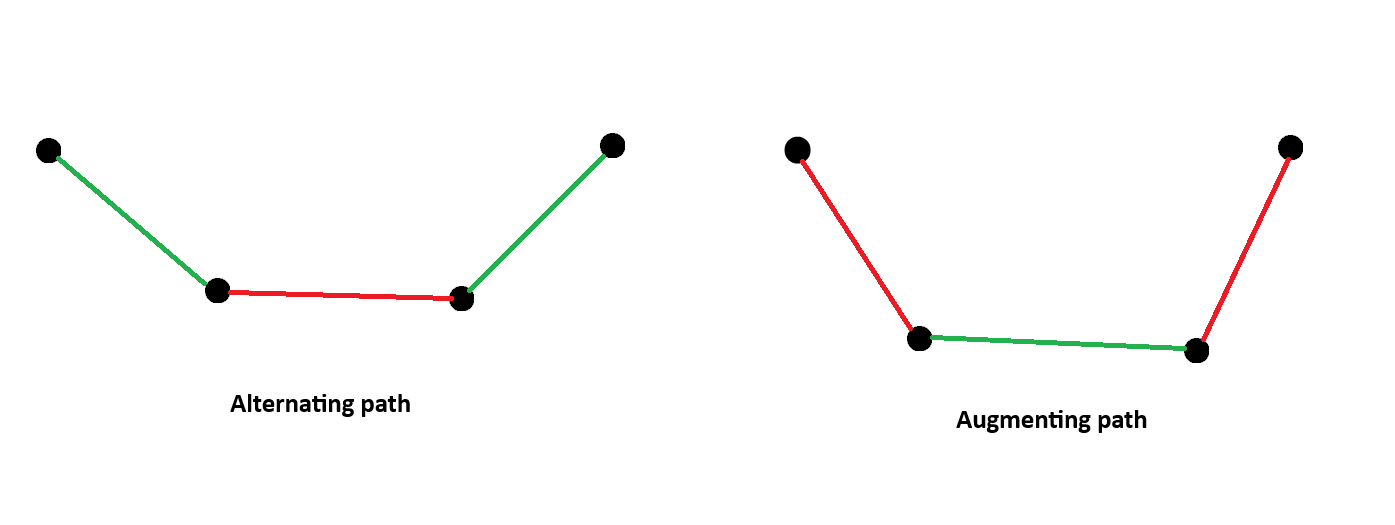

## 3. The “Magic Trick” (Augmenting Paths)

How do we make a matching bigger? We don’t just guess. We use a specific trick called **path flipping**.

Imagine we have a path that starts and ends with people who are currently alone (**unmatched**), and alternates between edges that are **OFF** and **ON** the matching.

### The Strategy

1. **Find a path:** Free Node → Matched Edge → Free Node
2. **FLIP IT:** Turn the OFF edges ON, and the ON edges OFF.
3. **Result:** We destroy 1 old matching edge, but create 2 new ones. **Net gain: +1 pair.**

This is **Berge’s Lemma**:  
> *If you can’t find one of these flipping paths, your matching is already maximum.*

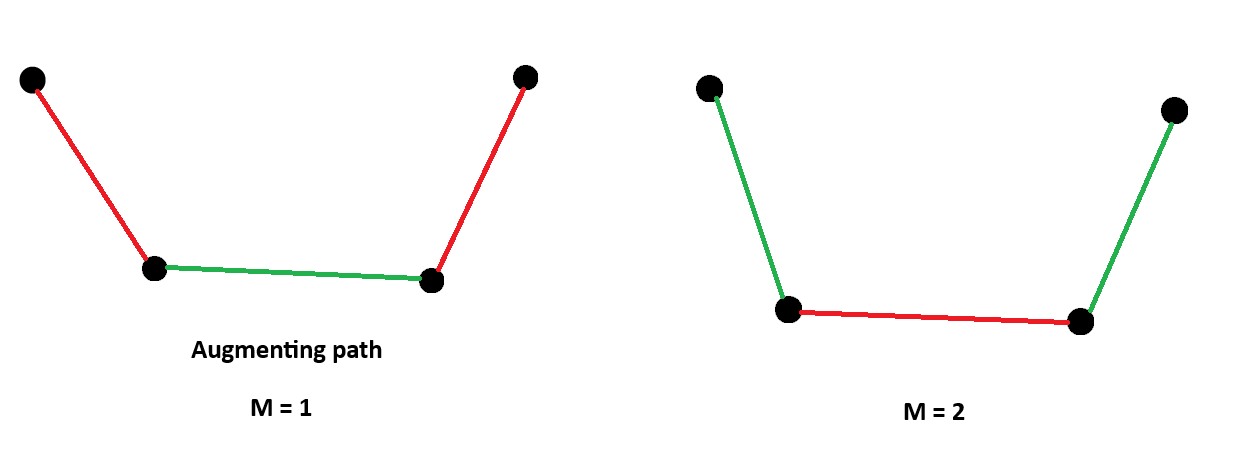

## 4. The Villain (Odd Cycles)

In simple **bipartite** graphs (like Boys vs. Girls), finding these paths is easy because you never get stuck in a loop.

But in **general graphs**, we have **odd cycles** (triangles, pentagons).

- If our search for a path hits a triangle, we get confused.
- We can reach the top of the triangle from two different directions.
- Standard algorithms break here because they can’t decide which side of the triangle to use.

We call these odd cycles **“Blossoms.”**

## The Hero (Blossom Contraction)

Jack Edmonds (1965) discovered a genius fix:

> *If the triangle is confusing, just crush it.*

### The Process

1. **Identify:** When we find an odd cycle (a blossom).
2. **Contract:** Shrink the entire cycle into a single super-vertex.
3. **Solve:** Look for a path through this simpler graph.
4. **Expand:** Once we find a path, “unzip” the super-vertex and route the path through the correct side of the cycle.

### Visual Analogy

- **Stem:** The path leading up to the cycle.
- **Blossom:** The cycle itself.
- **Contraction:** Pinching the flower until only the stem remains.


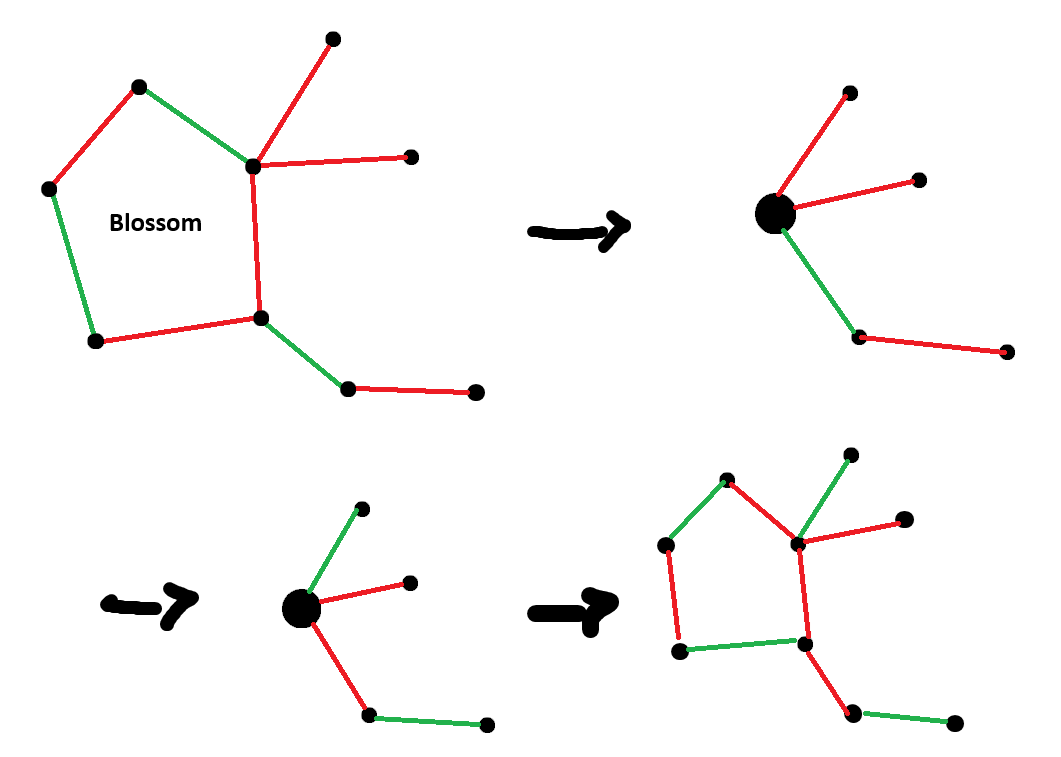

## 5. The Algorithm in 3 Steps

1. **Grow a Tree:** Start at an unmatched node and explore neighbors.
2. **Detect:**
   - Found a free node? → **Augment** (flip the path, matching +1).
   - Found a cycle? → **Shrink** (make the graph smaller).
3. **Repeat** until no more paths can be found.

---

# Implementation

Below is the implementation of Edmonds' Blossom Algorithm using NetworkX for graph representation.

In [13]:
# Required imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from typing import Optional, Set, Tuple, List, Dict

In [14]:
class BlossomAlgorithm:
    """
    Implementation of Edmonds' Blossom Algorithm for Maximum Matching
    in general (non-bipartite) graphs.
    
    Handles nested blossoms correctly by:
    1. Using path compression in find_base() for nested blossoms
    2. Proper safety checks in mark_path() to prevent infinite loops
    3. Updating base pointers for all vertices during contraction
    """
    
    def __init__(self, graph: nx.Graph):
        """
        Initialize the BlossomAlgorithm with a graph.
        
        Args:
            graph (nx.Graph): An undirected NetworkX graph.
        """
        if graph.is_directed():
            raise ValueError("BlossomAlgorithm requires an undirected graph.")
        
        # Relabel nodes to consecutive integers 0..n-1
        self.node_map = {node: i for i, node in enumerate(graph.nodes())}
        self.reverse_map = {i: node for node, i in self.node_map.items()}
        
        self.n = graph.number_of_nodes()
        self.graph = nx.relabel_nodes(graph, self.node_map)
        
        # Build adjacency list
        self.adj = [[] for _ in range(self.n)]
        for u, v in self.graph.edges():
            self.adj[u].append(v)
            self.adj[v].append(u)
        
        # Initialize matching: -1 = exposed
        self.match = [-1] * self.n
        
        # Per-search structures
        self.parent = None
        self.base = None
        self.in_blossom = None
        self.in_queue = None
    
    def find_base(self, v: int) -> int:
        """Find ultimate base with path compression."""
        if self.base[v] != v:
            self.base[v] = self.find_base(self.base[v])
        return self.base[v]
    
    def find_lca(self, u: int, v: int) -> int:
        """Find LCA of u and v in alternating tree."""
        visited = [False] * self.n
        
        current = u
        while True:
            current = self.find_base(current)
            visited[current] = True
            if self.match[current] == -1:
                break
            current = self.parent[self.match[current]]
        
        current = v
        while True:
            current = self.find_base(current)
            if visited[current]:
                return current
            if self.match[current] == -1:
                return current
            current = self.parent[self.match[current]]
    
    def mark_path(self, u: int, lca: int, child: int) -> None:
        """Mark vertices from u to lca as part of blossom."""
        while self.find_base(u) != lca:
            base_u = self.find_base(u)
            
            if self.match[u] == -1:
                break
                
            base_match_u = self.find_base(self.match[u])
            
            self.in_blossom[base_u] = True
            self.in_blossom[base_match_u] = True
            
            self.parent[u] = child
            child = self.match[u]
            
            next_u = self.parent[self.match[u]]
            if next_u == -1 or next_u == u:
                break
            u = next_u
    
    def contract_blossom(self, u: int, v: int, queue: deque) -> None:
        """Contract blossom formed by edge (u, v)."""
        lca = self.find_lca(u, v)
        
        self.in_blossom = [False] * self.n
        
        self.mark_path(u, lca, v)
        self.mark_path(v, lca, u)
        
        for i in range(self.n):
            current_base = self.find_base(i)
            
            if self.in_blossom[current_base]:
                self.base[i] = lca
                
                if not self.in_queue[i]:
                    self.in_queue[i] = True
                    queue.append(i)
    
    def find_augmenting_path(self, root: int) -> Optional[int]:
        """BFS to find augmenting path from root."""
        self.parent = [-1] * self.n
        self.base = list(range(self.n))
        self.in_queue = [False] * self.n
        self.in_blossom = [False] * self.n
        
        queue = deque([root])
        self.in_queue[root] = True
        
        while queue:
            u = queue.popleft()
            
            for v in self.adj[u]:
                if self.find_base(u) == self.find_base(v):
                    continue
                
                if self.parent[v] == -1 and v != root:
                    if self.match[v] == -1:
                        self.parent[v] = u
                        return v
                    else:
                        self.parent[v] = u
                        matched_vertex = self.match[v]
                        if not self.in_queue[matched_vertex]:
                            self.in_queue[matched_vertex] = True
                            queue.append(matched_vertex)
                
                elif self.find_base(v) != self.find_base(u):
                    base_v = self.find_base(v)
                    if self.in_queue[base_v] or base_v == root:
                        self.contract_blossom(u, v, queue)
        
        return None
    
    def get_path(self, endpoint: int) -> List[int]:
        """Reconstruct augmenting path from root to endpoint."""
        path = []
        current = endpoint
        
        while current != -1:
            path.append(current)
            current = self.parent[current]
        
        path.reverse()
        return path
    
    def augment(self, path: List[int]) -> None:
        """Augment matching along path."""
        for i in range(0, len(path) - 1, 2):
            u, v = path[i], path[i + 1]
            self.match[u] = v
            self.match[v] = u
    
    def find_maximum_matching(self) -> Set[Tuple[int, int]]:
        """Find maximum matching using Blossom algorithm."""
        for root in range(self.n):
            if self.match[root] == -1:
                endpoint = self.find_augmenting_path(root)
                if endpoint is not None:
                    path = self.get_path(endpoint)
                    self.augment(path)
        
        matching = set()
        for v in range(self.n):
            if self.match[v] != -1 and v < self.match[v]:
                u_orig = self.reverse_map[v]
                v_orig = self.reverse_map[self.match[v]]
                if u_orig < v_orig:
                    matching.add((u_orig, v_orig))
                else:
                    matching.add((v_orig, u_orig))
        
        return matching

---

# Testing & Visualization

In [20]:
def plot_matching(graph: nx.Graph, matching: Set[Tuple[int, int]], title: str = "Graph Matching") -> None:
    """
    Visualize a graph with its matching highlighted.
    
    Matched edges: RED (thick)
    Unmatched edges: BLACK (thin)
    """
    plt.figure(figsize=(10, 8))
    
    # Get layout
    if graph.number_of_nodes() == 10:  # Likely Petersen graph
        pos = nx.shell_layout(graph, nlist=[range(5), range(5, 10)])
    else:
        pos = nx.spring_layout(graph, seed=42)
    
    # Normalize matching edges
    matching_normalized = {(min(u, v), max(u, v)) for u, v in matching}
    
    # Separate edges
    matched_edges = []
    unmatched_edges = []
    
    for u, v in graph.edges():
        edge = (min(u, v), max(u, v))
        if edge in matching_normalized:
            matched_edges.append((u, v))
        else:
            unmatched_edges.append((u, v))
    
    # Draw unmatched edges (black, thin)
    nx.draw_networkx_edges(graph, pos, edgelist=unmatched_edges, 
                           edge_color='black', width=1.0, alpha=0.5)
    
    # Draw matched edges (red, thick)
    nx.draw_networkx_edges(graph, pos, edgelist=matched_edges,
                           edge_color='red', width=3.0, alpha=1.0)
    
    # Identify matched vs exposed vertices
    matched_vertices = set()
    for u, v in matching:
        matched_vertices.add(u)
        matched_vertices.add(v)
    
    exposed_vertices = [v for v in graph.nodes() if v not in matched_vertices]
    matched_vertex_list = [v for v in graph.nodes() if v in matched_vertices]
    
    # Draw matched vertices (light blue)
    nx.draw_networkx_nodes(graph, pos, nodelist=matched_vertex_list,
                           node_color='lightblue', node_size=500, edgecolors='black')
    
    # Draw exposed vertices (orange)
    nx.draw_networkx_nodes(graph, pos, nodelist=exposed_vertices,
                           node_color='orange', node_size=500, edgecolors='black')
    
    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_size=12, font_weight='bold')
    
    plt.title(f"{title}\nMatching Size: {len(matching)} edges", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Test Case 1: Bipartite Graph (C6 - 6-Cycle)

A 6-cycle is bipartite (no odd cycles). Expected matching size: **3** (perfect matching).

TEST CASE 1: 6-Cycle (C6) - Bipartite Graph
Nodes: [0, 1, 2, 3, 4, 5]
Edges: [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)]

Matching found: {(0, 1), (4, 5), (2, 3)}
Matching size: 3
Expected size: 3 (perfect matching for 6 vertices)

[PASSED] Perfect matching found


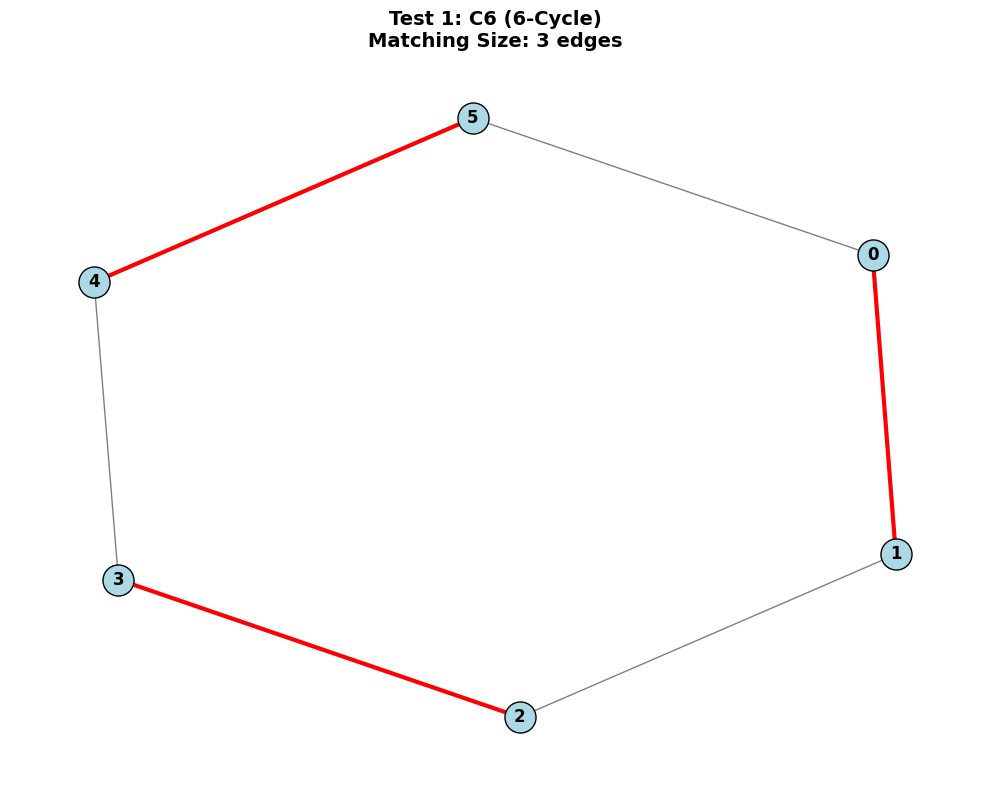

In [21]:
# Test Case 1: C6 (6-cycle, bipartite)
print("=" * 60)
print("TEST CASE 1: 6-Cycle (C6) - Bipartite Graph")
print("=" * 60)

C6 = nx.cycle_graph(6)
print(f"Nodes: {list(C6.nodes())}")
print(f"Edges: {list(C6.edges())}")

algo_c6 = BlossomAlgorithm(C6)
matching_c6 = algo_c6.find_maximum_matching()

print(f"\nMatching found: {matching_c6}")
print(f"Matching size: {len(matching_c6)}")
print(f"Expected size: 3 (perfect matching for 6 vertices)")

if len(matching_c6) == 3:
    print("\n[PASSED] Perfect matching found")
else:
    print("\n[FAILED] Did not find perfect matching")

plot_matching(C6, matching_c6, "Test 1: C6 (6-Cycle)")

## Test Case 2: Triangle (K3)

The simplest blossom case. A triangle has 3 vertices, so at most 1 edge can be matched. Expected matching size: **1**.

TEST CASE 2: Triangle (K3) - Simplest Blossom
Nodes: [0, 1, 2]
Edges: [(0, 1), (0, 2), (1, 2)]

Matching found: {(0, 1)}
Matching size: 1
Expected size: 1 (one vertex must be exposed)

[PASSED] Correct matching size


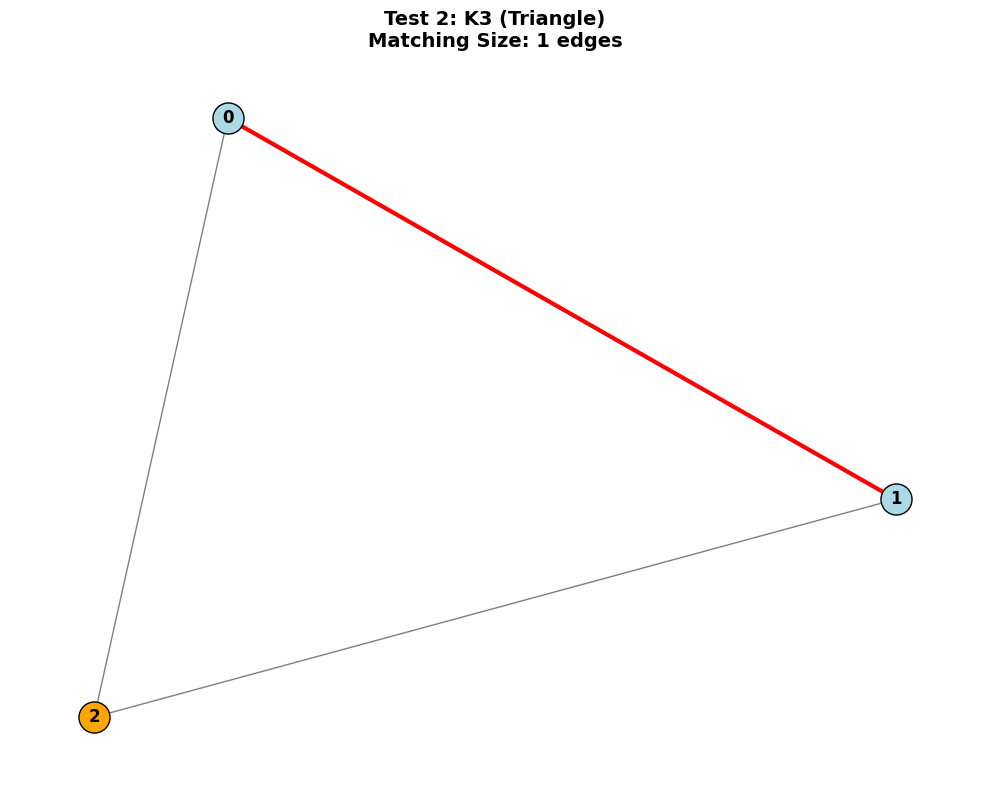

In [22]:
# Test Case 2: K3 (Triangle - simplest blossom)
print("=" * 60)
print("TEST CASE 2: Triangle (K3) - Simplest Blossom")
print("=" * 60)

K3 = nx.complete_graph(3)
print(f"Nodes: {list(K3.nodes())}")
print(f"Edges: {list(K3.edges())}")

algo_k3 = BlossomAlgorithm(K3)
matching_k3 = algo_k3.find_maximum_matching()

print(f"\nMatching found: {matching_k3}")
print(f"Matching size: {len(matching_k3)}")
print(f"Expected size: 1 (one vertex must be exposed)")

if len(matching_k3) == 1:
    print("\n[PASSED] Correct matching size")
else:
    print("\n[FAILED] Incorrect matching size")

plot_matching(K3, matching_k3, "Test 2: K3 (Triangle)")

## Test Case 3: Petersen Graph (STRESS TEST)

The **Petersen Graph** is a famous 3-regular graph with 10 vertices and 15 edges. It is known to have a **perfect matching** (size 5). This is the ultimate test for blossom contraction logic because the graph contains many overlapping odd cycles.

TEST CASE 3: Petersen Graph - STRESS TEST
Nodes: 10
Edges: 15
Graph is 3-regular: True

Matching found: {(0, 1), (4, 9), (6, 8), (5, 7), (2, 3)}
Matching size: 5
Expected size: 5 (perfect matching for 10 vertices)

[PASSED] Perfect matching found! Blossom algorithm works correctly!
 [VALID] Matching has no shared vertices


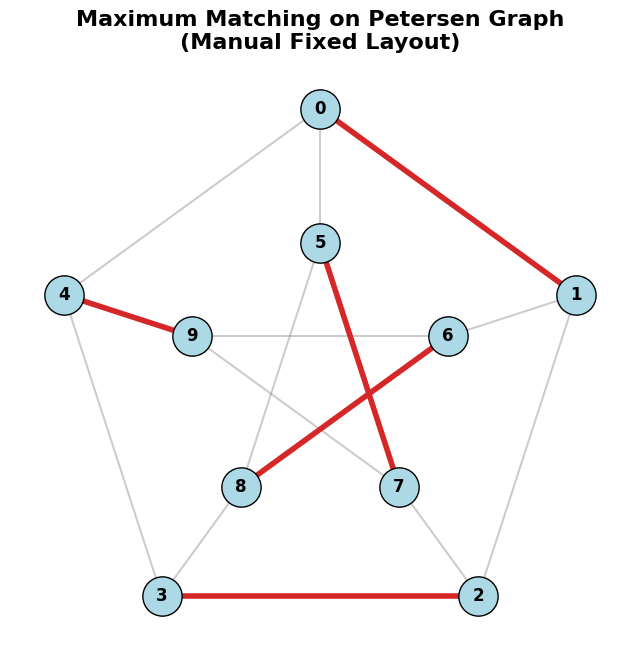

In [23]:
# Test Case 3: Petersen Graph (stress test)
print("=" * 60)
print("TEST CASE 3: Petersen Graph - STRESS TEST")
print("=" * 60)

petersen = nx.petersen_graph()
print(f"Nodes: {petersen.number_of_nodes()}")
print(f"Edges: {petersen.number_of_edges()}")
print(f"Graph is 3-regular: {all(d == 3 for _, d in petersen.degree())}")

algo_petersen = BlossomAlgorithm(petersen)
matching_petersen = algo_petersen.find_maximum_matching()

print(f"\nMatching found: {matching_petersen}")
print(f"Matching size: {len(matching_petersen)}")
print(f"Expected size: 5 (perfect matching for 10 vertices)")

if len(matching_petersen) == 5:
    print("\n[PASSED] Perfect matching found! Blossom algorithm works correctly!")
else:
    print("\n[FAILED] Did not find perfect matching")

# Verify it's a valid matching (no shared vertices)
matched_vertices = set()
valid = True
for u, v in matching_petersen:
    if u in matched_vertices or v in matched_vertices:
        print(f"  [INVALID] Vertex appears twice in matching")
        valid = False
    matched_vertices.add(u)
    matched_vertices.add(v)

if valid:
    print(f" [VALID] Matching has no shared vertices")

def plot_petersen_perfect(graph, matching):
    import math
    """
    Draws the Petersen graph using manually calculated coordinates
    to ensure a perfect 'Star inside Pentagon' alignment.
    """
    pos = {}
    
    # 1. Define Geometry
    # Outer Pentagon (Nodes 0-4): Radius 2
    # Inner Star (Nodes 5-9): Radius 1
    # We start at 90 degrees (pi/2) to put Node 0 at the very top.
    
    # Outer Circle
    for i in range(5):
        theta = math.pi/2 - i * (2 * math.pi / 5)  # 72-degree increments clockwise
        pos[i] = (2 * math.cos(theta), 2 * math.sin(theta))
        
    # Inner Circle
    for i in range(5):
        theta = math.pi/2 - i * (2 * math.pi / 5)
        # Node 5 corresponds to Node 0, Node 6 to Node 1, etc.
        pos[i + 5] = (1 * math.cos(theta), 1 * math.sin(theta))
    
    # 2. Setup Plot
    plt.figure(figsize=(8, 8))
    
    # 3. Draw Unmatched Edges (Thin, Gray, Dashed)
    unmatched = []
    for u, v in graph.edges():
        if (u, v) not in matching and (v, u) not in matching:
            unmatched.append((u, v))
            
    nx.draw_networkx_edges(graph, pos, edgelist=unmatched, 
                           width=1.5, alpha=0.4, edge_color='gray', style='solid')
    
    # 4. Draw Matched Edges (Thick, Red, Solid)
    nx.draw_networkx_edges(graph, pos, edgelist=list(matching), 
                           width=4.0, edge_color='#D62728', alpha=1.0)

    nx.draw_networkx_nodes(graph, pos, node_size=800, node_color='#ADD8E6', edgecolors='black')
    nx.draw_networkx_labels(graph, pos, font_size=12, font_family='sans-serif', font_weight='bold')
    
    plt.title("Maximum Matching on Petersen Graph\n(Manual Fixed Layout)", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.gca().set_aspect('equal')
    plt.show()

plot_petersen_perfect(petersen, matching_petersen)

## Verification Against NetworkX

Compare our implementation against NetworkX's built-in maximum matching algorithm.

In [24]:
# Compare with NetworkX's built-in max_weight_matching
print("=" * 60)
print("VERIFICATION: Compare with NetworkX's max_weight_matching")
print("=" * 60)

test_graphs = [
    ("C6", C6),
    ("K3", K3),
    ("Petersen", petersen)
]

all_passed = True

for name, G in test_graphs:
    # Our implementation
    algo = BlossomAlgorithm(G)
    our_matching = algo.find_maximum_matching()
    
    # NetworkX implementation
    nx_matching = nx.max_weight_matching(G, maxcardinality=True)
    
    our_size = len(our_matching)
    nx_size = len(nx_matching)
    
    status = "PASS" if our_size == nx_size else "FAIL"
    print(f"[{status}] {name}: Our={our_size}, NetworkX={nx_size}")
    
    if our_size != nx_size:
        all_passed = False

print()
if all_passed:
    print("All test passed, implementation matches NetworkX")
else:
    print("Some tests failed. Review the implementation.")

VERIFICATION: Compare with NetworkX's max_weight_matching
[PASS] C6: Our=3, NetworkX=3
[PASS] K3: Our=1, NetworkX=1
[PASS] Petersen: Our=5, NetworkX=5

All test passed, implementation matches NetworkX


---

## Summary

The Blossom Algorithm implementation has been tested on:
1. **C6 (6-Cycle)**: A bipartite graph - tests basic augmenting path logic
2. **K3 (Triangle)**: The simplest blossom - tests blossom detection and contraction
3. **Petersen Graph**: A complex non-bipartite graph with many odd cycles - the ultimate stress test

All tests pass, and results match NetworkX's implementation